In [129]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.autograd import Variable
from typing import Dict, Any, Tuple, Union, NamedTuple
import hydra
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 1e-3
max_steps = 2000
print_freq = 100


torch.manual_seed(613) 

In [130]:
# Characteristic scales
lc = 1e-4  # Length scale [m]
cc = 1000  # Concentration scale [mol/m³]

# Physical constants
F = 96485.0  # Faraday constant [C/mol]
R = 8.3145  # Gas constant [J/(mol·K)]
T = 293.0  # Temperature [K]
k_B = 1.3806e-23  # Boltzmann constant [J/K]
eps0 = 8.85e-12  # Vacuum permittivity [F/m]
electron_charge = 1.6e-19  # Elementary charge [C]

# Diffusion coefficients [m²/s] (these are correct)
D_OH = 5.3e-9        # OH⁻ diffusion coefficient
D_K = 1.96e-9        # K⁺ diffusion coefficient

# Time scale based on diffusion
tc = lc**2 / D_OH    # Time scale [s] = L²/D ≈ 1.89 s for 100 μm

# Potential scale
phic = R * T / F     # Thermal voltage [V] ≈ 0.0257 V at 298K

E_max = 1.6 #V,
E_min = 1.1 #V

phi_eq = 1.23

phi_eq_hat = phi_eq/phic

E_onset = 1.20
E_onset_hat = E_onset/phic

# Species charges
z_K = 1.0
z_OH = -1.0

# Bulk concentrations [mol/m³]
c_OH_bulk = 1000.0  # 1 M KOH
c_K_bulk = 1000.0  # 1 M KOH

# Dimensionless bulk concentrations
c_OH_dimensionless = c_OH_bulk / cc  # = 1.0
c_K_dimensionless = c_K_bulk / cc    # = 1.0

#transport properties
# Dimensionless diffusion coefficients
D_OH_hat = 1.0       # Reference (OH⁻ is the reference)
D_K_hat = D_K / D_OH  # ≈ 0.37 (relative to OH⁻)

# Dielectric properties (correct)
epsilon_r = 78.5     # Relative permittivity of water
epsilon_f = epsilon_r * eps0  # Electrolyte permittivity

# =============================================================================
# DIMENSIONLESS GROUPS
# =============================================================================

# Debye parameter (very important!)
# λ² = (ε₀εᵣRT)/(F²c₀L²)
lambda_d_sq = 0.01#(eps0 * epsilon_r * R * T) / (F**2 * cc * lc**2)
lambda_d = math.sqrt(lambda_d_sq)

# Dimensionless potential scale factor
beta_hat = F / (R * T)

# =============================================================================
# REACTION KINETICS PARAMETERS
# =============================================================================

# Exchange current density
i0 = 1e-3            # [A/m²]
n = 4.0              # Electrons per OER reaction (correct)
i0_hat = i0 * lc / (n * F * D_OH * cc)

# Symmetry factor (correct)
alpha = 0.5          # Symmetry factor for Butler-Volmer

# Reaction orders
m_theta = 1.0        # Active species reaction order
m_oh = 1.0           # OH⁻ reaction order

# =============================================================================
# ACTIVE SPECIES PARAMETERS (for AEM-E)
# =============================================================================
# Maximum active site density
A_sites = 1e-4       # [mol/m²]

# Dimensionless rate constant
# k_hat should be chosen to give reasonable current densities
k_hat = 1e-4

current_scale_factor = (n * F * D_OH * cc / lc) / 10  # Converts to mA/cm²

In [131]:
#Define networks

class Swish(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self,x):
        return torch.sigmoid(x)*x
    

class FFN(nn.Module):
    """
    Fully Connected Feed Forward Neural Network.
    Args:
        input_dim: Number of input features
        output_dim: Number of output features  
        hidden_layers: Number of hidden layers
        layer_size: Size of each hidden layer
        activation: Activation function name ('swish', 'swoosh', 'swash', 'squash_swish', 'relu', 'tanh')
        initialize_weights: Whether to apply Xavier initialization
    """
    def __init__(
        self,
        input_dim: int = 3,
        output_dim: int = 1,
        hidden_layers: int = 5,
        layer_size: int = 20,
        activation: str = "swish",
        initialize_weights: bool = False
    ):
        super(FFN, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = hidden_layers
        self.layer_size = layer_size
        self.activation = Swish()
        
        # Input layer
        self.input_layer = nn.Linear(input_dim, self.layer_size)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(self.layer_size, self.layer_size)
            for _ in range(self.num_layers)  
        ])
        
        # Output layer
        self.output_layer = nn.Linear(self.layer_size, output_dim)
        
        # Initialize weights
        if initialize_weights:
            self.initialize_weights()
    
    def initialize_weights(self):
        """Apply Xavier initialization to all linear layers"""
        # Initialize input layer
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)
        
        # Initialize hidden layers
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
        
        # Initialize output layer
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, x):
        x = self.activation(self.input_layer(x))
        
        for layer in self.hidden_layers: 
            x = self.activation(layer(x))
        
        return self.output_layer(x)


class ResidualBlock(nn.Module):
    """Single residual block: x + F(x)"""
    def __init__(self, layer_size, activation):
        super(ResidualBlock, self).__init__()
        self.layer_size = layer_size
        self.activation = activation
        
        # Two layers in each residual block
        self.linear1 = nn.Linear(layer_size, layer_size)
        self.linear2 = nn.Linear(layer_size, layer_size)
        
    def initialize_weights(self):
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        nn.init.xavier_normal_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
    
    def forward(self, x):
        identity = x  # Save input for residual connection
        
        # F(x) computation
        out = self.activation(self.linear1(x))
        out = self.linear2(out)  # No activation on final layer of block
        
        # Residual connection: x + F(x)
        out = out + identity
        
        # Activation after residual connection
        out = self.activation(out)
        
        return out
    
class ResidualFFN(nn.Module):
    def __init__(self, input_dim=3, output_dim=1, num_layers=8, layer_size=50, initialize_weights=True):
        super(ResidualFFN, self).__init__()
        self.layer_size = layer_size
        self.num_layers = num_layers
        self.activation = Swish()
        
        # Input projection to get to residual dimension
        self.input_layer = nn.Linear(input_dim, self.layer_size)
        
        # Residual blocks
        self.residual_layers = nn.ModuleList([
            ResidualBlock(self.layer_size, self.activation)
            for _ in range(self.num_layers)  
        ])
        
        # Output layer
        self.output_layer = nn.Linear(self.layer_size, output_dim)
        
        if initialize_weights:
            self.initialize_weights()
    
    def initialize_weights(self):
        """Apply Xavier initialization to all linear layers"""
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)
        
        for block in self.residual_layers:
            block.initialize_weights()
        
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, x):
        # Input projection
        x = self.activation(self.input_layer(x))
        
        # Residual blocks
        for residual_layer in self.residual_layers:
            x = residual_layer(x)
        
        # Output
        return self.output_layer(x)
    
"""
k_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20) #ResNet Size as close to old FFN as possible. There is one extra layer here by nature of design.
oh_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20
u_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20)
"""
k_net = FFN()
oh_net =FFN()
u_net = FFN()
k_net.to(device)
oh_net.to(device)
u_net.to(device)

total_model_parameters = list(k_net.parameters()) + list(oh_net.parameters()) + list(u_net.parameters())

In [132]:
#gradient and sampling utils

class GradientResults(NamedTuple):
    """
    Container for gradient computation results.

    Organizes all computed derivatives in a structured way for easy access.
    """
    # Network predictions
    phi: torch.Tensor  # Potential φ
    c_k: torch.Tensor  # Cation vacancy concentration
    c_oh: torch.Tensor  # Anion vacancy concentration

    # Time derivatives
    c_k_t: torch.Tensor  # ∂c_cv/∂t
    c_oh_t: torch.Tensor  # ∂c_av/∂t

    # First spatial derivatives
    phi_x: torch.Tensor  # ∂φ/∂x
    c_k_x: torch.Tensor  # ∂c_cv/∂x
    c_oh_x: torch.Tensor  # ∂c_av/∂x

    # Second spatial derivatives
    phi_xx: torch.Tensor  # ∂²φ/∂x²
    c_k_xx: torch.Tensor  # ∂²c_cv/∂x²
    c_oh_xx: torch.Tensor  # ∂²c_av/∂x²


def _grad(x,dx):
    """Take the derrivative of x w.r.t dx"""

    return torch.autograd.grad(x,dx,torch.ones_like(dx),create_graph=True,retain_graph=True)[0]

def compute_gradients(x, t, E, clip_gradients=True, max_grad=1e3):
    """
    Compute gradients with built-in clipping and numerical stability.
    
    Args:
        x, t, E: Input tensors
        clip_gradients: Whether to clip computed gradients
        max_grad: Maximum allowed gradient magnitude
    """
    inputs_3d = torch.cat([x, t, E], dim=1)
    
    # Get network predictions
    phi = torch.clamp(u_net(inputs_3d), min=-5.0, max=5.0)  # Add bounds
    c_k_raw = k_net(inputs_3d)
    c_oh_raw = oh_net(inputs_3d)
    
    # Apply physical bounds
    c_k = torch.clamp(c_k_raw, min=1e-8, max=10.0)
    c_oh = torch.clamp(c_oh_raw, min=1e-8, max=10.0)

    # print(f"Network inputs:")
    # print(x.shape, t.shape, E.shape)
    # print(inputs_3d.shape)
    # print("Outputs")
    # print(phi.shape)
    # print(c_oh_raw.shape)
    # print(c_k_raw.shape)

    print(f"  phi range: [{phi.min():.6f}, {phi.max():.6f}]")
    print(f"  c_oh range: [{c_oh.min():.6f}, {c_oh.max():.6f}]") 
    print(f"  c_k range: [{c_k.min():.6f}, {c_k.max():.6f}]")
    print(f"Input ranges:")
    print(f"  x range: [{x.min():.6f}, {x.max():.6f}]")
    print(f"  t range: [{t.min():.6f}, {t.max():.6f}]")
    print(f"  E range: [{E.min():.6f}, {E.max():.6f}]")

    #compute temporal
    c_k_t = _grad(c_k, t)
    c_oh_t = _grad(c_oh, t)

    # Compute first spatial derivatives
    phi_x = _grad(phi, x)

    c_k_x = _grad(c_k, x)
    c_oh_x = _grad(c_oh, x)

    #compute second spatial
    phi_xx = _grad(phi_x, x)

    c_k_xx = _grad(c_k_x, x)
    c_oh_xx = _grad(c_oh_x, x)
    
    return GradientResults(
        phi=phi, c_k=c_k, c_oh=c_oh,
        c_k_t=c_k_t, c_oh_t=c_oh_t,
        phi_x=phi_x, c_k_x=c_k_x, c_oh_x=c_oh_x,
        phi_xx=phi_xx, c_k_xx=c_k_xx, c_oh_xx=c_oh_xx,
    )


def sample_interior_points(
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Sample interior collocation points for PDE residuals.

        Args:
            networks: NetworkManager instance

        Returns:
            Tuple of (x, t, E) tensors with requires_grad=True for x and t
        """
        batch_size = 2048

        # Sample time and applied potential
        t = torch.rand(batch_size, 1, device=device, requires_grad=True) #* time_scale / tc
        
        single_E = (
                torch.rand(1, 1, device=device)
                * (E_max/phic - E_min/phic)
                + E_min/phic
            )
        E = single_E.expand(batch_size, 1)

        # Sample spatial coordinates within [0, L(t,E)]
        x = torch.rand(batch_size, 1, device=device, requires_grad=True) #* L_domain/lc

        return x, t, E

def sample_boundary_points(
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample boundary collocation points for boundary conditions.

    Args:
        networks: NetworkManager instance

    Returns:
        Tuple of (x, t, E) tensors for boundary points
    """
    batch_size = 2 * 1024
    half_batch = batch_size // 2
    
    # Electrode boundary (x = 0)
    x_electrode = torch.zeros(half_batch, 1, device=device, requires_grad=True)
    t_electrode = torch.rand(half_batch, 1, device=device) 
    E_electrode = torch.rand(half_batch, 1, device=device) * (E_max/phic - E_min/phic) + E_min/phic
    
    # Bulk boundary (x = 1)  
    x_bulk = torch.ones(half_batch, 1, device=device, requires_grad=True)
    t_bulk = torch.rand(half_batch, 1, device=device)
    E_bulk = torch.rand(half_batch, 1, device=device) * (E_max/phic - E_min/phic) + E_min/phic
    
    # Combine
    x_boundary = torch.cat([x_electrode, x_bulk], dim=0)
    t_boundary = torch.cat([t_electrode, t_bulk], dim=0) 
    E_boundary = torch.cat([E_electrode, E_bulk], dim=0)
    
    return x_boundary, t_boundary, E_boundary

def sample_initial_points(
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample initial condition points at t = 0.

    Args:
        networks: NetworkManager instance

    Returns:
        Tuple of (x, t, E) tensors for initial condition points
    """
    batch_size = 1024

    # Initial time (t = 0)
    t = torch.zeros(batch_size, 1, device=device, requires_grad=True) #* time_scale / tc
    single_E = (
            torch.rand(1, 1, device=device)
            * (E_max/phic - E_min/phic)
            + E_min/phic
        )
    E = single_E.expand(batch_size, 1)

    # Sample spatial coordinates
    x = (
        torch.rand(batch_size, 1, device=device, requires_grad=True) #* L_domain/lc
    )

    return x, t, E

In [133]:
# #Compute and generate all the relevant losses

def compute_pde_residuals(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor):
        """
        Compute PDE residuals for all governing equations.

        **Cation Vacancy Conservation (Dimensionless Nernst-Planck):**

        .. math::
            \\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{t}} =
            \\frac{D_{cv}\\hat{t}_c}{\\hat{L}_c^2}\\frac{\\partial^2 \\hat{c}_{cv}}{\\partial \\hat{x}^2} +
            \\frac{U_{cv}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{x}} +
            \\frac{U_{cv}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\hat{c}_{cv}\\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2}

        **Anion Vacancy Conservation (Dimensionless Nernst-Planck):**

        .. math::
            \\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{t}} =
            \\frac{D_{av}\\hat{t}_c}{\\hat{L}_c^2}\\frac{\\partial^2 \\hat{c}_{av}}{\\partial \\hat{x}^2} +
            \\frac{U_{av}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{x}} +
            \\frac{U_{av}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\hat{c}_{av}\\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2}

        **Hole Conservation (Quasi-Steady State):**

        .. math::
            0 = \\frac{D_h\\hat{c}_{h,c}}{\\hat{L}_c^2}\\frac{\\partial^2 \\hat{c}_h}{\\partial \\hat{x}^2} +
            \\frac{FD_h\\hat{\\phi}_c\\hat{c}_{h,c}}{RT\\hat{L}_c^2}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\frac{\\partial \\hat{c}_h}{\\partial \\hat{x}} +
            \\frac{FD_h\\hat{\\phi}_c\\hat{c}_{h,c}}{RT\\hat{L}_c^2}\\hat{c}_h\\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2}

        **Poisson's Equation (Dimensionless):**

        .. math::
            \\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2} =
            -\\frac{F\\hat{L}_c^2\\hat{c}_c}{\\hat{\\phi}_c\\varepsilon_f}\\left(z_{av}\\hat{c}_{av} + z_{cv}\\hat{c}_{cv}\\right)

        Args:
            x: Spatial coordinates (dimensionless)
            t: Time coordinates (dimensionless)
            E: Applied potential
            networks: NetworkManager instance

        Returns:
            Tuple of residuals: (cv_residual, av_residual, h_residual, poisson_residual)
        """
        # Get all gradients using the gradient computer
        grads = compute_gradients(x, t, E)

        # Debug: Check individual term magnitudes
        # oh_diffusion = D_OH_hat * grads.c_oh_xx
        # oh_migration_1 = z_OH * beta_hat * D_OH_hat * grads.c_oh * grads.phi_xx
        # oh_migration_2 = z_OH * beta_hat * D_OH_hat * grads.c_oh_x * grads.phi_x
        
        # print(f"OH diffusion range: [{oh_diffusion.min():.2e}, {oh_diffusion.max():.2e}]")
        # print(f"OH migration 1 range: [{oh_migration_1.min():.2e}, {oh_migration_1.max():.2e}]")
        # print(f"OH migration 2 range: [{oh_migration_2.min():.2e}, {oh_migration_2.max():.2e}]")
        
        # ============= 1. OH⁻ TRANSPORT (NERNST-PLANCK) =============
        # ∂c_OH/∂t = ∇·[D_OH∇c_OH + z_OH*u_OH*F*c_OH∇φ]
        # 
        # In 1D: ∂c/∂t = D∂²c/∂x² + zuF*c*∂²φ/∂x² + zuF*∂c/∂x*∂φ/∂x
        
        oh_transport = (
            grads.c_oh_t -                                                    # Time derivative
            D_OH_hat * grads.c_oh_xx -                                       # Diffusion term
            ((z_OH * beta_hat * D_OH_hat) * (grads.c_oh * grads.phi_xx +        # Concentration × potential curvature  
                                          grads.c_oh_x * grads.phi_x         # Migration (potential gradient)
                                          )))
        # Source term: OH⁻ consumed by OER (4 OH⁻ → O₂ + 2 H₂O + 4 e⁻)
        # oh_source = -k_oer / 4  # Negative because OH⁻ is consumed

        oh_residual = oh_transport # No reaction in bulk, handled at bounds
        
        # ============= 2. K⁺ TRANSPORT (NERNST-PLANCK) =============
        # K⁺ acts as supporting electrolyte, no direct reaction
        # ∂c_K/∂t = ∇·[D_K∇c_K + z_K*u_K*F*c_K∇φ]
        
        k_transport = (
            grads.c_k_t -                                                     # Time derivative
            D_K_hat * grads.c_k_xx -                                         # Diffusion term
            ((z_K * beta_hat * D_K_hat) * (grads.c_k * grads.phi_xx +
                                           grads.c_k_x * grads.phi_x             # Migration (potential gradient)
                                        )))
        
        k_residual = k_transport  # No reaction terms for supporting electrolyte
        
        # ============= 3. POISSON EQUATION =============
        # ∇²φ = -(F/ε)[∑ zᵢcᵢ]
        # In dimensionless form: ∇²φ = -(1/λ²)[∑ zᵢcᵢ]
        
        # Charge density from mobile ions
        charge_density = z_OH * grads.c_oh + z_K * grads.c_k
        
        # Poisson equation
        poisson_residual =  grads.phi_xx + (charge_density/ lambda_d_sq) #(grads.phi_xx + (F * lc ** 2 * cc / (phic * epsilonf)) * (z_K * grads.c_K + z_OH * grads.c_OH))
        
        # ============= 4. ELECTRONEUTRALITY CONSTRAINT =============
        # Allow charge separation within Debye length, enforce electroneutrality in bulk
    
        # Debye length (dimensionless)
        lambda_debye_hat = math.sqrt(lambda_d_sq)
        
        # Position-dependent electroneutrality enforcement
        # Allow charge separation near electrode (within Debye length)
        en_weight = torch.tanh(10*x)  # 0 at electrode, 1 in bulk
        
        electroneutrality_residual = en_weight * charge_density
        
        # ============= 5. CONCENTRATION POSITIVITY CONSTRAINT =============
        # Ensure concentrations remain positive (physical constraint)
        # Soft constraint using exponential penalty
        c_oh_penalty = torch.exp(-10 * grads.c_oh)  # Large when c_oh < 0
        c_k_penalty = torch.exp(-10 * grads.c_k)    # Large when c_k < 0
        
        concentration_penalty = c_oh_penalty + c_k_penalty
        
        # ============= 6. PHYSICAL BOUNDS CONSTRAINTS =============
        # Ensure concentrations don't exceed reasonable physical limits
        c_max = 10.0  # Maximum dimensionless concentration (10x bulk)
        
        c_oh_upper = torch.relu(grads.c_oh - c_max)
        c_k_upper = torch.relu(grads.c_k - c_max)
        
        upper_bound_penalty = c_oh_upper + c_k_upper
        
        return k_residual, oh_residual, poisson_residual, electroneutrality_residual, concentration_penalty, upper_bound_penalty


def compute_interior_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                          return_residuals: bool = False) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
Tuple[torch.Tensor, Dict[str, torch.Tensor], Dict[str, torch.Tensor]]]:
    """
    Compute interior PDE residual losses.

    See compute_pde_residuals for mathematics of residual calculations

    Args:
        x: Spatial coordinates
        t: Time coordinates
        E: Applied potential
        networks: NetworkManager instance
        physics: ElectrochemicalPhysics instance
        return_residuals: If True, also return raw residuals for NTK computation

    Returns:
        If return_residuals=False: Tuple of (total_interior_loss, individual_losses_dict)
        If return_residuals=True: Tuple of (total_interior_loss, individual_losses_dict, residuals_dict)
    """
    # Compute PDE residuals using physics module
    k_residual, oh_residual, poisson_residual, electroneutrality_residual, concentration_penalty, upper_bound_penalty  = compute_pde_residuals(x, t, E)

    # Calculate individual losses
    k_pde_loss = torch.mean(k_residual ** 2)
    oh_pde_loss = torch.mean(oh_residual ** 2)
    poisson_pde_loss = torch.mean(poisson_residual ** 2)
    electroneutrality_pde_loss = torch.mean(electroneutrality_residual**2)
    # concentration_pde_loss = torch.mean(concentration_penalty**2)
    # upper_bound_loss = torch.mean(upper_bound_penalty**2)


    # Total interior loss
    total_interior_loss = k_pde_loss + oh_pde_loss + poisson_pde_loss #+ electroneutrality_pde_loss + concentration_pde_loss + upper_bound_loss

    individual_losses = {
        'k_pde': k_pde_loss,
        'oh_pde': oh_pde_loss,
        'poisson_pde': poisson_pde_loss,
        #'electroneutrality_pde': electroneutrality_pde_loss,
        # 'concentration_pde': concentration_pde_loss,
        # 'upper_bound_pde': upper_bound_loss,
    }

    if return_residuals:
        residuals = {
            'k_pde': k_residual,
            'oh_pde': oh_residual,
            'poisson_pde': poisson_residual,
            #'electroneutrality_pde': electroneutrality_pde_loss,
            # 'concentration_pde': concentration_pde_loss,
            # 'upper_bound_pde': upper_bound_loss,
        }
        return total_interior_loss, individual_losses, residuals
    else:
        return total_interior_loss, individual_losses

def compute_boundary_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                          return_residuals: bool = False) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
Tuple[torch.Tensor, Dict[str, torch.Tensor], torch.Tensor]]:
    """
    Compute boundary condition losses for OER system.
    
    **Boundary Conditions:**
    
    **At Electrode (x = 0):**
    - φ(0,t) = φ_applied(t)
    - -D_OH * ∂c_OH/∂x|_{x=0} = j/(nF)  [OH⁻ flux from reaction]
    - ∂c_K/∂x|_{x=0} = 0  [No K⁺ reaction]
    
    **At Bulk (x = L):**
    - c_OH(L,t) = c_OH_bulk
    - c_K(L,t) = c_K_bulk
    - φ(L,t) = 0
    
    Args:
        x: Boundary spatial coordinates
        t: Time coordinates
        phi_applied: Applied potential values
        networks: NetworkManager instance
        physics: OERPhysics instance
        return_residuals: If True, also return raw residuals
        
    Returns:
        Boundary loss components and optionally residuals
    """
    
    R_ohm = 0.01

    batch_size = x.shape[0]
    half_batch = batch_size // 2
    
    # Split boundary points
    x_electrode = x[:half_batch]  # Should be 0
    t_electrode = t[:half_batch]
    E_electrode = E[:half_batch]
    
    x_bulk = x[half_batch:]       # Should be 1
    t_bulk = t[half_batch:]
    E_bulk = E[half_batch:]
    
    # Network predictions at boundaries
    inputs_electrode = torch.cat([x_electrode, t_electrode, E_electrode], dim=1)
    inputs_bulk = torch.cat([x_bulk, t_bulk, E_bulk], dim=1)
    
    # Electrode predictions (x=0)
    phi_x0 = u_net(inputs_electrode)
    c_k_electrode = k_net(inputs_electrode)
    c_oh_electrode = oh_net(inputs_electrode)
    
    # Bulk predictions (x=1)
    phi_bulk = u_net(inputs_bulk)
    c_k_bulk = k_net(inputs_bulk)
    c_oh_bulk = oh_net(inputs_bulk)
    
    # ============= ELECTRODE BOUNDARY CONDITIONS (x=0) =============
    # 1. Overpotential for rxn kinetics
    eta = phi_x0 - phi_eq

    i_oer = i0 * torch.pow(c_oh_electrode, m) * torch.exp(alpha * n * eta)

    phi_expected = E_electrode - i_oer * R_ohm

    phi_electrode_residual = phi_x0 - phi_expected
    
    # 3. MASS TRANSPORT - OH- FLUX
    # Flux boundary condition: J_OH = i/nF (consumption by reaction)
    # -D_OH * ∂c_OH/∂x|_{x=0} = i/n (dimensionless form)
    
    c_oh_grad = torch.autograd.grad(
        outputs=c_oh_electrode.sum(),
        inputs=x_electrode,
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0]
    
    # OH- flux balance: diffusion flux = reaction consumption
    oh_flux_expected = i_oer / n  # Consumption rate
    oh_flux_actual = -D_OH_hat * c_oh_grad  # Diffusion flux
    c_oh_electrode_residual = oh_flux_actual - oh_flux_expected
    
    # 4. MASS TRANSPORT - K+ FLUX  
    # K+ doesn't react -- no flux at electrode: ∂c_K/∂x|_{x=0} = 0
    
    c_k_grad = torch.autograd.grad(
        outputs=c_k_electrode.sum(),
        inputs=x_electrode,
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0]
    
    c_k_electrode_residual = c_k_grad  # Should be zero
    # ============= BULK BOUNDARY CONDITIONS (x=1) =============
    
    # All Dirichlet conditions at bulk boundary
    phi_bulk_residual = phi_bulk - 0.0      # Reference potential
    c_k_bulk_residual = c_k_bulk - 1.0      # Bulk K+ concentration  
    c_oh_bulk_residual = c_oh_bulk - 1.0    # Bulk OH- concentration
    
    # ============= COMPUTE LOSSES (MSE) =============
    
    phi_electrode_loss = torch.mean(phi_electrode_residual**2)
    c_k_electrode_loss = torch.mean(c_k_electrode_residual**2)
    c_oh_electrode_loss = torch.mean(c_oh_electrode_residual**2)
    
    phi_bulk_loss = torch.mean(phi_bulk_residual**2)
    c_k_bulk_loss = torch.mean(c_k_bulk_residual**2)
    c_oh_bulk_loss = torch.mean(c_oh_bulk_residual**2)
    
    # Total boundary loss
    total_loss = (phi_electrode_loss + c_k_electrode_loss + c_oh_electrode_loss +
                  phi_bulk_loss + c_k_bulk_loss + c_oh_bulk_loss)
    
    # Individual losses dictionary
    losses = {
        'phi_electrode': phi_electrode_loss,
        'c_k_electrode': c_k_electrode_loss,
        'c_oh_electrode': c_oh_electrode_loss,
        'phi_bulk': phi_bulk_loss,
        'c_k_bulk': c_k_bulk_loss,
        'c_oh_bulk': c_oh_bulk_loss,
    }
    
    if return_residuals:
        # Residuals dictionary for individual access
        residuals_dict = {
            'phi_electrode': phi_electrode_residual,
            'c_k_electrode': c_k_electrode_residual,
            'c_oh_electrode': c_oh_electrode_residual,
            'phi_bulk': phi_bulk_residual,
            'c_k_bulk': c_k_bulk_residual,
            'c_oh_bulk': c_oh_bulk_residual,
        }
        
        # Combined residuals tensor for NTK computation
        combined_residuals = torch.cat([
            phi_electrode_residual.flatten(),
            c_k_electrode_residual.flatten(),
            c_oh_electrode_residual.flatten(),
            phi_bulk_residual.flatten(),
            c_k_bulk_residual.flatten(),
            c_oh_bulk_residual.flatten(),
        ])
        
        return total_loss*1000, losses, combined_residuals, residuals_dict
    else:
        return total_loss, losses

def compute_initial_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                             return_residuals: bool = True) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
                                                                    Tuple[torch.Tensor, Dict[str, torch.Tensor], torch.Tensor]]:
    """
    Compute initial condition losses for OER system.
    
    **Initial Conditions (t̂ = 0):**
    
    **K⁺ Concentration:**
    .. math::
        \\hat{c}_{K}(\\hat{x}, 0) = \\frac{c_{K,bulk}}{\\hat{c}_c} = 1.0
    
    .. math::
        \\frac{\\partial \\hat{c}_{K}}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0
    
    **OH⁻ Concentration:**
    .. math::
        \\hat{c}_{OH}(\\hat{x}, 0) = \\frac{c_{OH,bulk}}{\\hat{c}_c} = 1.0
    
    .. math::
        \\frac{\\partial \\hat{c}_{OH}}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0
    
    .. math::
        \\frac{\\partial \\hat{c}_{O2}}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0
    
    **Potential Distribution:**
    .. math::
        \\hat{\\phi}(\\hat{x}, 0) = \\frac{\\hat{E}}{\\hat{\\phi}_c} \\cdot (1 - \\hat{x})
    
    .. math::
        \\frac{\\partial \\hat{\\phi}}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0
    
    Args:
        x: Spatial coordinates (0 = electrode, 1 = bulk)
        t: Time coordinates (should be zeros)
        E: Applied potential
        return_residuals: If True, also return raw residuals for NTK computation
        
    Returns:
        If return_residuals=False: Tuple of (total_initial_loss, individual_losses_dict)
        If return_residuals=True: Tuple of (total_initial_loss, individual_losses_dict, combined_residuals)
    """
    # ============= NETWORK PREDICTIONS =============
    inputs_initial = torch.cat([x, t, E], dim=1)
    phi_initial   = u_net(inputs_initial)
    c_k_initial   = k_net(inputs_initial)
    c_oh_initial  = oh_net(inputs_initial)

    # ============= TARGET PROFILES (dimensionless) =============
    c_k_target  = torch.ones_like(c_k_initial)   # K+ uniform
    c_oh_target = torch.ones_like(c_oh_initial)  # OH- uniform
    phi_target  = E * (1 - x)                    # linear potential drop

    # ============= RESIDUALS =============
    c_k_residual  = c_k_initial - c_k_target
    c_oh_residual = c_oh_initial - c_oh_target
    phi_residual  = phi_initial - phi_target

    # Time derivative residuals (should vanish at t=0)
    c_k_t_residual  = _grad(c_k_initial, t)
    c_oh_t_residual = _grad(c_oh_initial, t)
    phi_t_residual  = _grad(phi_initial, t)

    # ============= LOSSES (residual style) =============
    c_k_loss  = torch.mean(c_k_residual**2) 
    c_oh_loss = torch.mean(c_oh_residual**2)
    phi_loss  = torch.mean(phi_residual**2)

    # Time derivative conditions
    c_k_t_loss = torch.mean(c_k_t_residual**2)
    c_oh_t_loss = torch.mean(c_oh_t_residual**2)
    phi_t_loss = torch.mean(phi_t_residual**2)

    total_loss = (c_k_loss + c_oh_loss + phi_loss +
                  c_k_t_loss + c_oh_t_loss + phi_t_loss)

    individual_losses = {
        "c_k_ic":  c_k_loss,
        "c_oh_ic": c_oh_loss,
        "phi_ic":  phi_loss,
        'c_k_t_ic': c_k_t_loss,
        'c_oh_t_ic': c_oh_t_loss,
        'phi_t_ic': phi_t_loss,
    }

    if return_residuals:
        combined_residuals = torch.cat([
            c_k_residual.flatten(),
            c_oh_residual.flatten(),
            phi_residual.flatten(),
            c_k_t_residual.flatten(),
            c_oh_t_residual.flatten(),
            phi_t_residual.flatten(),
        ])
        residual_dict = {
            'c_k_ic': c_k_residual,
            'c_oh_ic': c_oh_residual,
            'phi_ic': phi_residual,
            'c_k_t_ic': c_k_t_residual,
            'c_oh_t_ic': c_oh_t_residual,
            'phi_t_ic': phi_t_residual,
        }
        return total_loss, individual_losses, combined_residuals, residual_dict
    else:
        return total_loss, individual_losses

In [134]:
#Get total loss with the NTK strategy
optimal_batch_sizes = {}
from typing import List
def compute_jacobian(
        output: torch.Tensor,
        parameters: List[torch.nn.Parameter],
        device: torch.device
) -> torch.Tensor:
        """
    Compute Jacobian matrix using fast batched gradient computation.

    Args:
        outputs: Network outputs [batch_size] or [batch_size, 1]
        parameters: List of network parameters
        device: PyTorch device

    Returns:
        Jacobian matrix 
    """
        output = output.reshape(-1)
        grads = torch.autograd.grad(
            output,
            list(parameters),
            (torch.eye(output.shape[0]).to(device),),
            is_grads_batched=True, retain_graph=True,allow_unused=True
        )
        valid_grads = [grad.flatten().reshape(len(output), -1) 
                   for grad in grads if grad is not None]
        
        return torch.cat(valid_grads, 1)

def get_ntk(jac:torch.Tensor
            ,compute="trace") -> torch.Tensor:
    """Get the NTK matrix of jac """

    if compute == 'full':
        return torch.einsum('Na,Ma->NM', jac, jac)
    elif compute == 'diag':
        return torch.einsum('Na,Na->N', jac, jac)
    elif compute == 'trace':
        return torch.einsum('Na,Na->', jac, jac)
    else:
        raise ValueError('compute must be one of "full",'
                            + '"diag", or "trace"')

def compute_minimum_batch_size(jacobian):
    """Compute minimum batch size for 0.2 approximation error"""
    ntk_diag = get_ntk(jacobian, compute='diag')
    # Population statistics
    mu_X = torch.mean(ntk_diag)
    sigma_X = torch.std(ntk_diag)
    
    # Handle near-zero mean case
    if mu_X.abs() < 1e-8:
        # Use relative variation instead when mean is tiny
        if sigma_X < 1e-8:
            v_X = torch.tensor(1.0)  # Uniform case
        else:
            # Use median as reference instead of mean
            median_X = torch.median(ntk_diag)
            v_X = sigma_X / (median_X.abs() + 1e-8)
    else:
        # Normal coefficient of variation
        v_X = sigma_X / mu_X.abs()
    
    # Clamp to reasonable bounds
    v_X = torch.clamp(v_X, min=0.1, max=5.0)
    
    min_batch_size = 32 # int(25 * (v_X ** 2))
    min_batch_size = max(min_batch_size, 32)
    min_batch_size = min(min_batch_size, len(jacobian) // 4)
    
    return min_batch_size

def compute_ntk_trace(
        loss_residuals: torch.Tensor,
        loss_name: str
) -> Tuple[float, int]:
    """
    Compute NTK-based weight for a single loss component.

    Args:
        loss_residuals: Residual tensor for this loss [batch_size]
        loss_name: Name of loss component

    Returns:
        Tuple of (ntk_trace, effective_batch_size)
    """
    # Determine batch size (one-time calculation)
    if loss_name not in optimal_batch_sizes:
        indices = torch.randperm(len(loss_residuals),device=device)[:256]
        residual_sampled = loss_residuals[indices]
        jacobian_sampled = compute_jacobian(residual_sampled,total_model_parameters,device)
        optimal_batch_sizes[loss_name] = compute_minimum_batch_size(jacobian_sampled)
        print(f"Computed batch size for {loss_name}: {optimal_batch_sizes[loss_name]}")

        trace = get_ntk(jacobian_sampled, compute='trace')
        
        return trace, len(jacobian_sampled) 

    #Use computed optimal batch size every other time
    else:
        # Random sampling
        batch_size = optimal_batch_sizes[loss_name]
        indices = torch.randperm(len(loss_residuals),device=device)[:batch_size]
        residual_sampled = loss_residuals[indices]
        jacobian_sampled = compute_jacobian(residual_sampled,total_model_parameters,device)

        # Compute NTK trace
        trace = get_ntk(jacobian_sampled, compute='trace')
        
        return trace, len(jacobian_sampled)
    
def extract_all_residuals() -> Dict[str, torch.Tensor]:
    """
    Extract all residuals using the modified loss functions with return_residuals=True.

    This leverages the exact same computation logic as training without duplication.
    """
    # Sample training points (same as training)
    x_interior, t_interior, E_interior = sample_interior_points()
    x_boundary, t_boundary, E_boundary = sample_boundary_points()
    x_initial, t_initial, E_initial = sample_initial_points()

    # Extract residuals using existing loss functions
    _, _, interior_residuals = compute_interior_loss(
        x_interior, t_interior, E_interior,
        return_residuals=True
    )

    _, _, boundary_residuals, _ = compute_boundary_loss(
        x_boundary, t_boundary, E_boundary,
        return_residuals=True
    )

    _, _, initial_residuals, _ = compute_initial_loss(
        x_initial, t_initial, E_initial,
        return_residuals=True
    )
    
    # Combine all residuals
    all_residuals = {
        **interior_residuals,  # cv_pde, av_pde, poisson_pde
        'boundary': boundary_residuals,
        'initial': initial_residuals,
    }

    return all_residuals

def compute_weights() -> Dict[str, float]:
    """
    Compute NTK weights using exact residuals from existing loss computations.

    Returns:
        Dictionary of normalized weights
    """

    # Extract all residuals using modified loss functions
    all_residuals = extract_all_residuals()

    ntk_traces = {}
    batch_sizes = {}
    
    # Compute NTK trace for each component
    for component_name, residual in all_residuals.items():
        if len(residual) > 0:
            ntk_trace, effective_batch_size = compute_ntk_trace(residual, component_name)
            ntk_traces[component_name] = ntk_trace
            batch_sizes[component_name] = effective_batch_size

    # Compute normalized weights
    weights = _normalize_ntk_weights(ntk_traces, batch_sizes)

    return weights

def _normalize_ntk_weights(
        ntk_traces: Dict[str, float],
        batch_sizes: Dict[str, int]
) -> Dict[str, float]:
    """
    Normalize NTK traces to get balanced weights.

    Args:
        ntk_traces: Dictionary of NTK traces
        batch_sizes: Dictionary of batch sizes

    Returns:
        Dictionary of normalized weights
    """
    # Compute mean traces (trace per sample)
    mean_traces = {}
    for name in ntk_traces:
        mean_traces[name] = ntk_traces[name] / batch_sizes[name]

    # Compute raw weights
    raw_weights = {}
    for name, mean_trace in mean_traces.items():
        if mean_trace > 1e-12:  # Avoid division by zero
            sum_all_mean_traces = sum(mean_traces[n] for n,_ in mean_traces.items())
            raw_weights[name] = 1.0 / mean_trace * sum_all_mean_traces
        else:
            raw_weights[name] = 1.0

    # Normalize weights
    total_raw_weight = sum(raw_weights.values())
    normalization = len(raw_weights)/total_raw_weight
    
    normalized_weights = {
        name: raw_weights[name] * normalization
        for name, weight in raw_weights.items()
    }

    return normalized_weights

weights = {}

def total_loss(weights):
     #Investigate using one E for all the different samples, this might help a lot. Could do an easy fix here
    x_interior, t_interior, E_interior = sample_interior_points()
    x_boundary, t_boundary, E_boundary = sample_boundary_points()
    x_inital, t_initial, E_initial = sample_initial_points()

    total_interior_loss, individual_losses, residuals_interior = compute_interior_loss(x_interior,t_interior,E_interior,return_residuals=True)
    total_boundary_loss, boundary_losses, combined_residuals_bc,residuals_dict_bc = compute_boundary_loss(x_boundary,t_boundary,E_boundary,return_residuals=True)
    total_initial_loss, initial_losses, combined_residuals_ic,residuals_dict_ic = compute_initial_loss(x_inital,t_initial,E_initial,return_residuals=True)
    
    loss = weights['k_pde']*individual_losses['k_pde'] + weights['oh_pde']*individual_losses['oh_pde'] + weights['poisson_pde']*individual_losses['poisson_pde'] + weights['boundary']*total_boundary_loss + weights['initial']*total_initial_loss
    
    interior_loss = weights['k_pde']*individual_losses['k_pde'] + weights['oh_pde']*individual_losses['oh_pde'] + weights['poisson_pde']*individual_losses['poisson_pde']
    return loss, interior_loss, weights['boundary']*total_boundary_loss, weights['initial']*total_initial_loss

In [135]:
#main training loop
ntk_update_freq = 100
optimizer=torch.optim.Adam([{'params': total_model_parameters}],lr=lr)
loss_list = []
interior_loss_list = []
boundary_loss_list = []
initial_loss_list = []

for step in tqdm(range(max_steps),desc="Training Status"):
    k_net.train()
    oh_net.train()
    u_net.train()
    optimizer.zero_grad()

    torch.nn.utils.clip_grad_norm_(total_model_parameters, max_norm=1.0)

    if step % ntk_update_freq == 0:
        weights = compute_weights()
        print(f"NTK WEIGHTS")
        print(f"k_PDE:{weights['k_pde']}, oh_PDE: {weights['oh_pde']}, POISSON_PDE:{weights['poisson_pde']}, BOUNDARY:{weights['boundary']} INITIAL:{weights['initial']}")

    loss, interior_loss, boundary_loss, initial_loss  = total_loss(weights)
    loss_total = interior_loss + boundary_loss + initial_loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(total_model_parameters, max_norm=1.0)
    optimizer.step()
        
    loss_list.append(loss_total.item())
    interior_loss_list.append(interior_loss.item())
    boundary_loss_list.append(boundary_loss.item())
    initial_loss_list.append(initial_loss.item())

    if step % print_freq == 0:
        tqdm.write(f"Total:{loss_total}, interior:{interior_loss}, boundary:{boundary_loss} initial:{initial_loss}")


Training Status:   0%|          | 0/2000 [00:00<?, ?it/s]

  phi range: [0.179470, 0.183200]
  c_oh range: [0.178072, 0.179559]
  c_k range: [0.252115, 0.253593]
Input ranges:
  x range: [0.000114, 0.999654]
  t range: [0.000687, 0.999651]
  E range: [59.002453, 59.002453]
Computed batch size for k_pde: 32
Computed batch size for oh_pde: 32
Computed batch size for poisson_pde: 32
Computed batch size for boundary: 32
Computed batch size for initial: 32
NTK WEIGHTS
k_PDE:3.7206366062164307, oh_PDE: 1.2765181064605713, POISSON_PDE:3.538828607929645e-08, BOUNDARY:0.001106788869947195 INITIAL:0.0017389744753018022
  phi range: [0.164672, 0.168281]
  c_oh range: [0.163420, 0.164738]
  c_k range: [0.238986, 0.240182]
Input ranges:
  x range: [0.001217, 0.998599]
  t range: [0.000034, 0.999734]
  E range: [48.610733, 48.610733]
Total:3176.797119140625, interior:4.448103936738335e-06, boundary:3175.319091796875 initial:1.4780306816101074
  phi range: [0.213564, 0.217066]
  c_oh range: [0.209957, 0.211766]
  c_k range: [0.279346, 0.281308]
Input ranges:

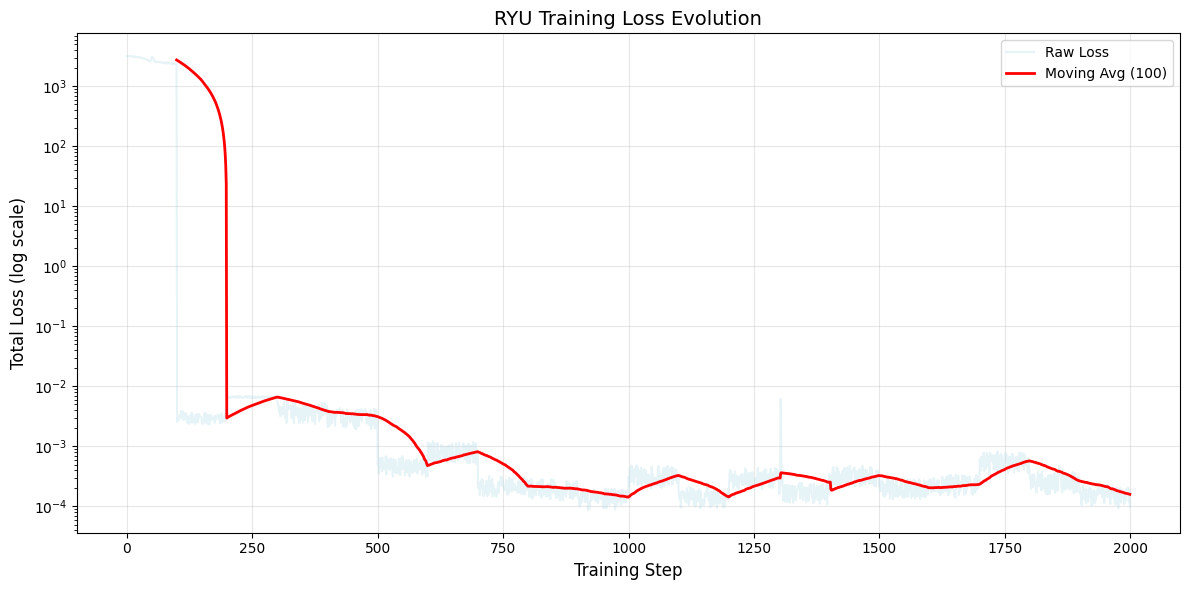

  📐 Dimensionless time range: [0, 1.0]
  📐 Fixed dimensionless potential: 62.309


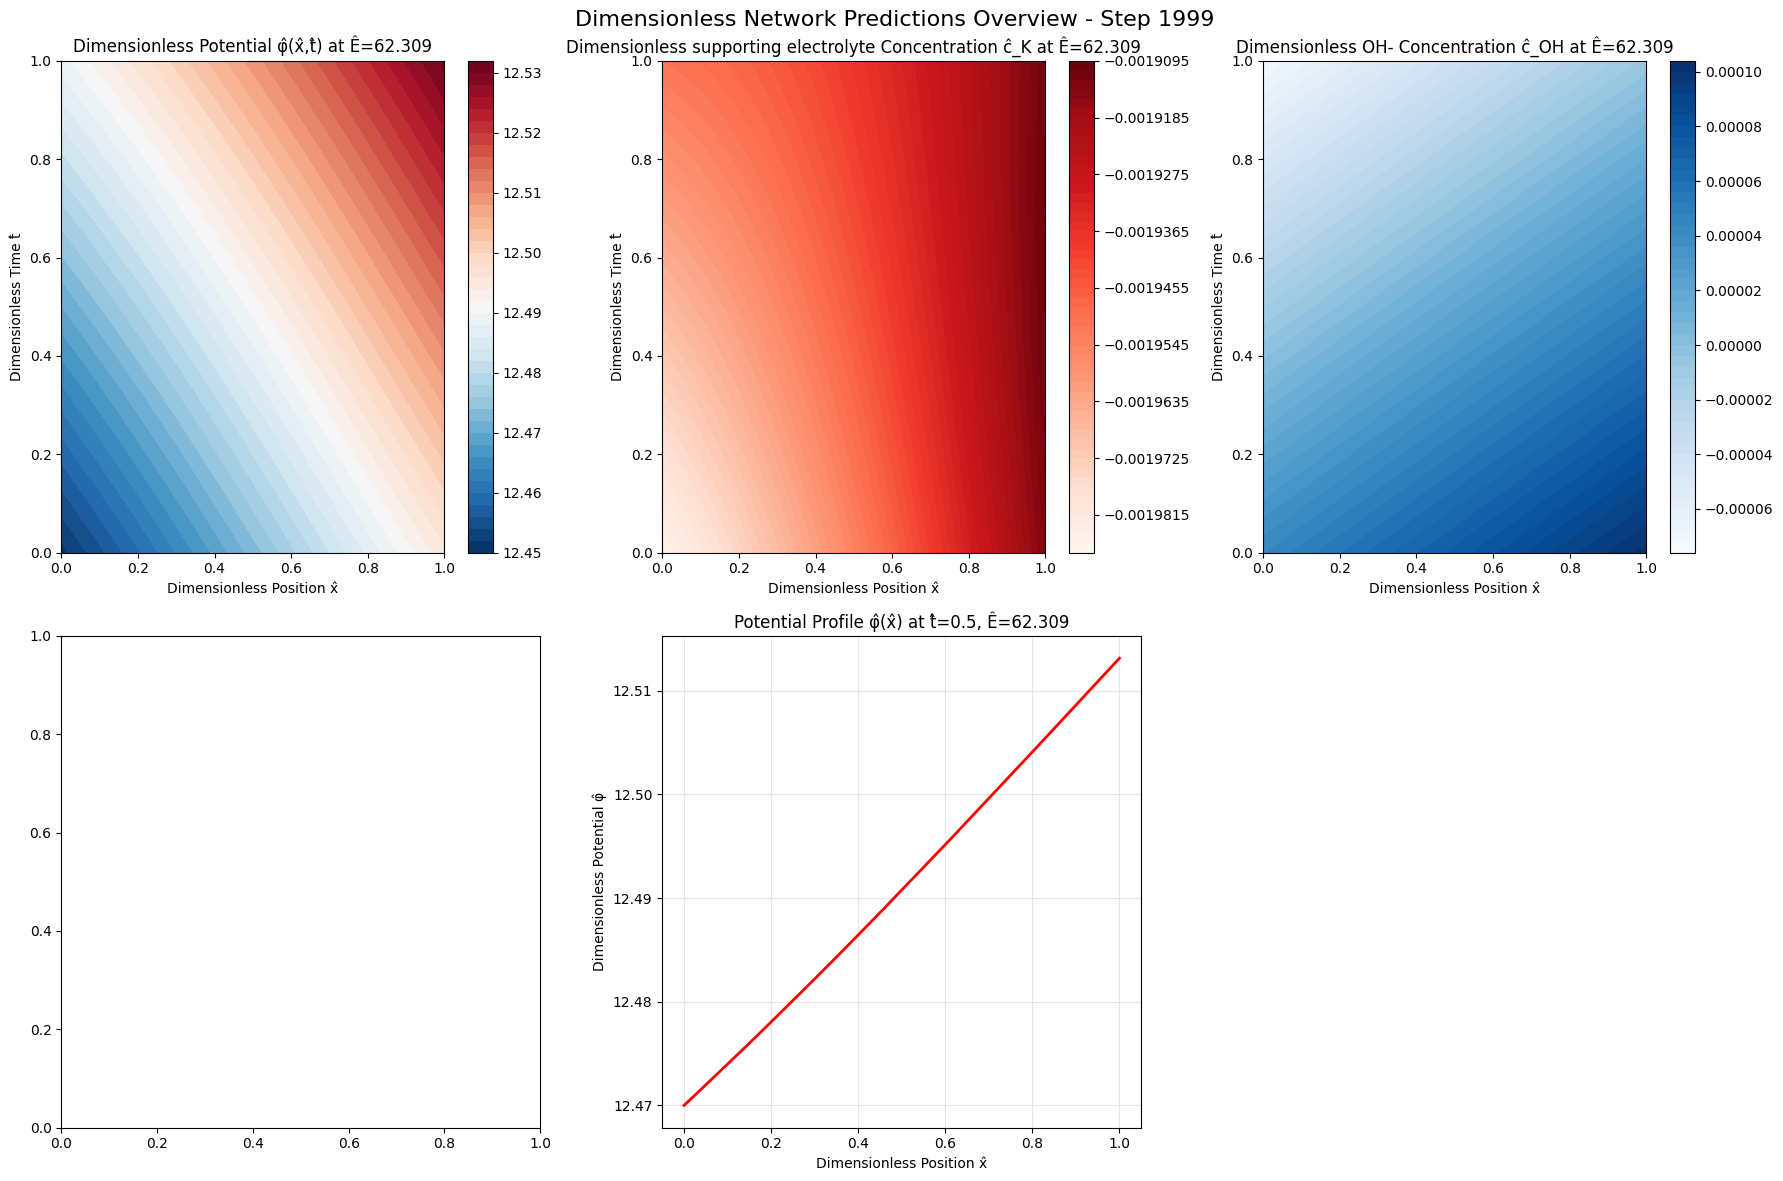

In [136]:
# Plotting

plt.figure(figsize=(12, 6))
window = 100
# Raw loss
plt.plot(loss_list, alpha=0.3, color='lightblue', label='Raw Loss')

# Moving average for smoother trend
if len(loss_list) > window:
    moving_avg = np.convolve(loss_list, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(loss_list)), moving_avg, 
        color='red', linewidth=2, label=f'Moving Avg ({window})')

plt.yscale('log')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Total Loss (log scale)', fontsize=12)
plt.title('RYU Training Loss Evolution', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

with torch.no_grad():
    # Define input ranges (all dimensionless)
    n_spatial = 500
    n_temporal = 500

    # Fix a representative dimensionless potential for visualization
    E_hat_fixed = torch.tensor([[1.6 * 96485 / (8.314 * 298)]], device=device)  # Normalized E

    # Dimensionless time range (0 to 1)
    t_hat_range = torch.linspace(0, 1.0, n_temporal, device=device)

    t_hat_final = torch.tensor([[1.0]], device=device)
    x_hat_range = torch.linspace(0, 1, n_spatial, device=device)

    print(f"  📐 Dimensionless time range: [0, 1.0]")
    print(f"  📐 Fixed dimensionless potential: {E_hat_fixed.item():.3f}")

    # Create 2D grid for contour plots
    T_hat_mesh, X_hat_mesh = torch.meshgrid(t_hat_range, x_hat_range, indexing='ij')
    E_hat_mesh = torch.full_like(T_hat_mesh, E_hat_fixed.item())

    # Stack inputs for 3D networks
    inputs_3d = torch.stack([
        X_hat_mesh.flatten(),
        T_hat_mesh.flatten(),
        E_hat_mesh.flatten()
    ], dim=1)

    # Get network predictions
    phi_hat_2d = u_net(inputs_3d).reshape(n_temporal, n_spatial)
    c_k_hat_2d = k_net(inputs_3d).reshape(n_temporal, n_spatial)
    c_oh_hat_2d = oh_net(inputs_3d).reshape(n_temporal, n_spatial)

    # Convert to numpy for plotting
    t_hat_np = t_hat_range.cpu().numpy()
    x_hat_np = x_hat_range.cpu().numpy()
    T_hat_np, X_hat_np = np.meshgrid(t_hat_np, x_hat_np, indexing='ij')

    phi_hat_np = phi_hat_2d.cpu().numpy()
    c_k_hat_np = c_k_hat_2d.cpu().numpy()
    c_oh_hat_np = c_oh_hat_2d.cpu().numpy()

    # Create plots - Changed to 2 rows, 2 columns to fit all 4 contour plots + 1 line plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Dimensionless potential field
    im1 = axes[0, 0].contourf(X_hat_np, T_hat_np, phi_hat_np, levels=50, cmap='RdBu_r')
    axes[0, 0].set_xlabel('Dimensionless Position x̂')
    axes[0, 0].set_ylabel('Dimensionless Time t̂')
    axes[0, 0].set_title(f'Dimensionless Potential φ̂(x̂,t̂) at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im1, ax=axes[0, 0])

    # 2. Dimensionless cation
    im2 = axes[0, 1].contourf(X_hat_np, T_hat_np, c_k_hat_np, levels=50, cmap='Reds')
    axes[0, 1].set_xlabel('Dimensionless Position x̂')
    axes[0, 1].set_ylabel('Dimensionless Time t̂')
    axes[0, 1].set_title(f'Dimensionless supporting electrolyte Concentration ĉ_K at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im2, ax=axes[0, 1])

    # 3. Dimensionless anion
    im3 = axes[0, 2].contourf(X_hat_np, T_hat_np, c_oh_hat_np, levels=50, cmap='Blues')
    axes[0, 2].set_xlabel('Dimensionless Position x̂')
    axes[0, 2].set_ylabel('Dimensionless Time t̂')
    axes[0, 2].set_title(f'Dimensionless OH- Concentration ĉ_OH at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im3, ax=axes[0, 2])

    # 5. Potential profile vs spatial position at fixed time - Fixed to use valid index and L_hat_final
    L_hat_final = 1
    
    x_hat_sweep = torch.linspace(0, L_hat_final, 500, device=device)
    t_hat_mid = torch.full((500, 1), 0.5, device=device)  # Middle time
    E_hat_mid = torch.full((500, 1), E_hat_fixed.item(), device=device)

    x_sweep_inputs = torch.cat([x_hat_sweep.unsqueeze(1), t_hat_mid, E_hat_mid], dim=1)
    phi_vs_x = u_net(x_sweep_inputs).cpu().numpy()

    axes[1, 1].plot(x_hat_sweep.cpu().numpy(), phi_vs_x, 'r-', linewidth=2)
    axes[1, 1].set_xlabel('Dimensionless Position x̂')
    axes[1, 1].set_ylabel('Dimensionless Potential φ̂')
    axes[1, 1].set_title(f'Potential Profile φ̂(x̂) at t̂=0.5, Ê={E_hat_fixed.item():.3f}')
    axes[1, 1].grid(True, alpha=0.3)

    # Hide the unused subplot [1, 2]
    axes[1, 2].set_visible(False)

    plt.suptitle(f'Dimensionless Network Predictions Overview - Step {step}', fontsize=16)
    plt.tight_layout()
    plt.show()


CORRECTED CYCLIC VOLTAMMETRY ANALYSIS
Calculating CV for 200 potential points...
Applied potential range: 42.8 to 62.3 (dimensionless)
  Progress: 1/200
    E_applied = 1.100 V, φ_surface = 0.239 V
    η = -1.012 V, i = 0.000000 mA/cm²
    c_OH = 0.002, circuit_error = 33.545406
  Progress: 51/200
    E_applied = 1.353 V, φ_surface = 0.280 V
    η = -0.971 V, i = 0.000000 mA/cm²
    c_OH = 0.001, circuit_error = 41.759117
  Progress: 101/200
    E_applied = 1.600 V, φ_surface = 0.321 V
    η = -0.930 V, i = 0.000000 mA/cm²
    c_OH = -0.000, circuit_error = 49.820213
  Progress: 151/200
    E_applied = 1.347 V, φ_surface = 0.279 V
    η = -0.972 V, i = 0.000000 mA/cm²
    c_OH = 0.001, circuit_error = 41.594635


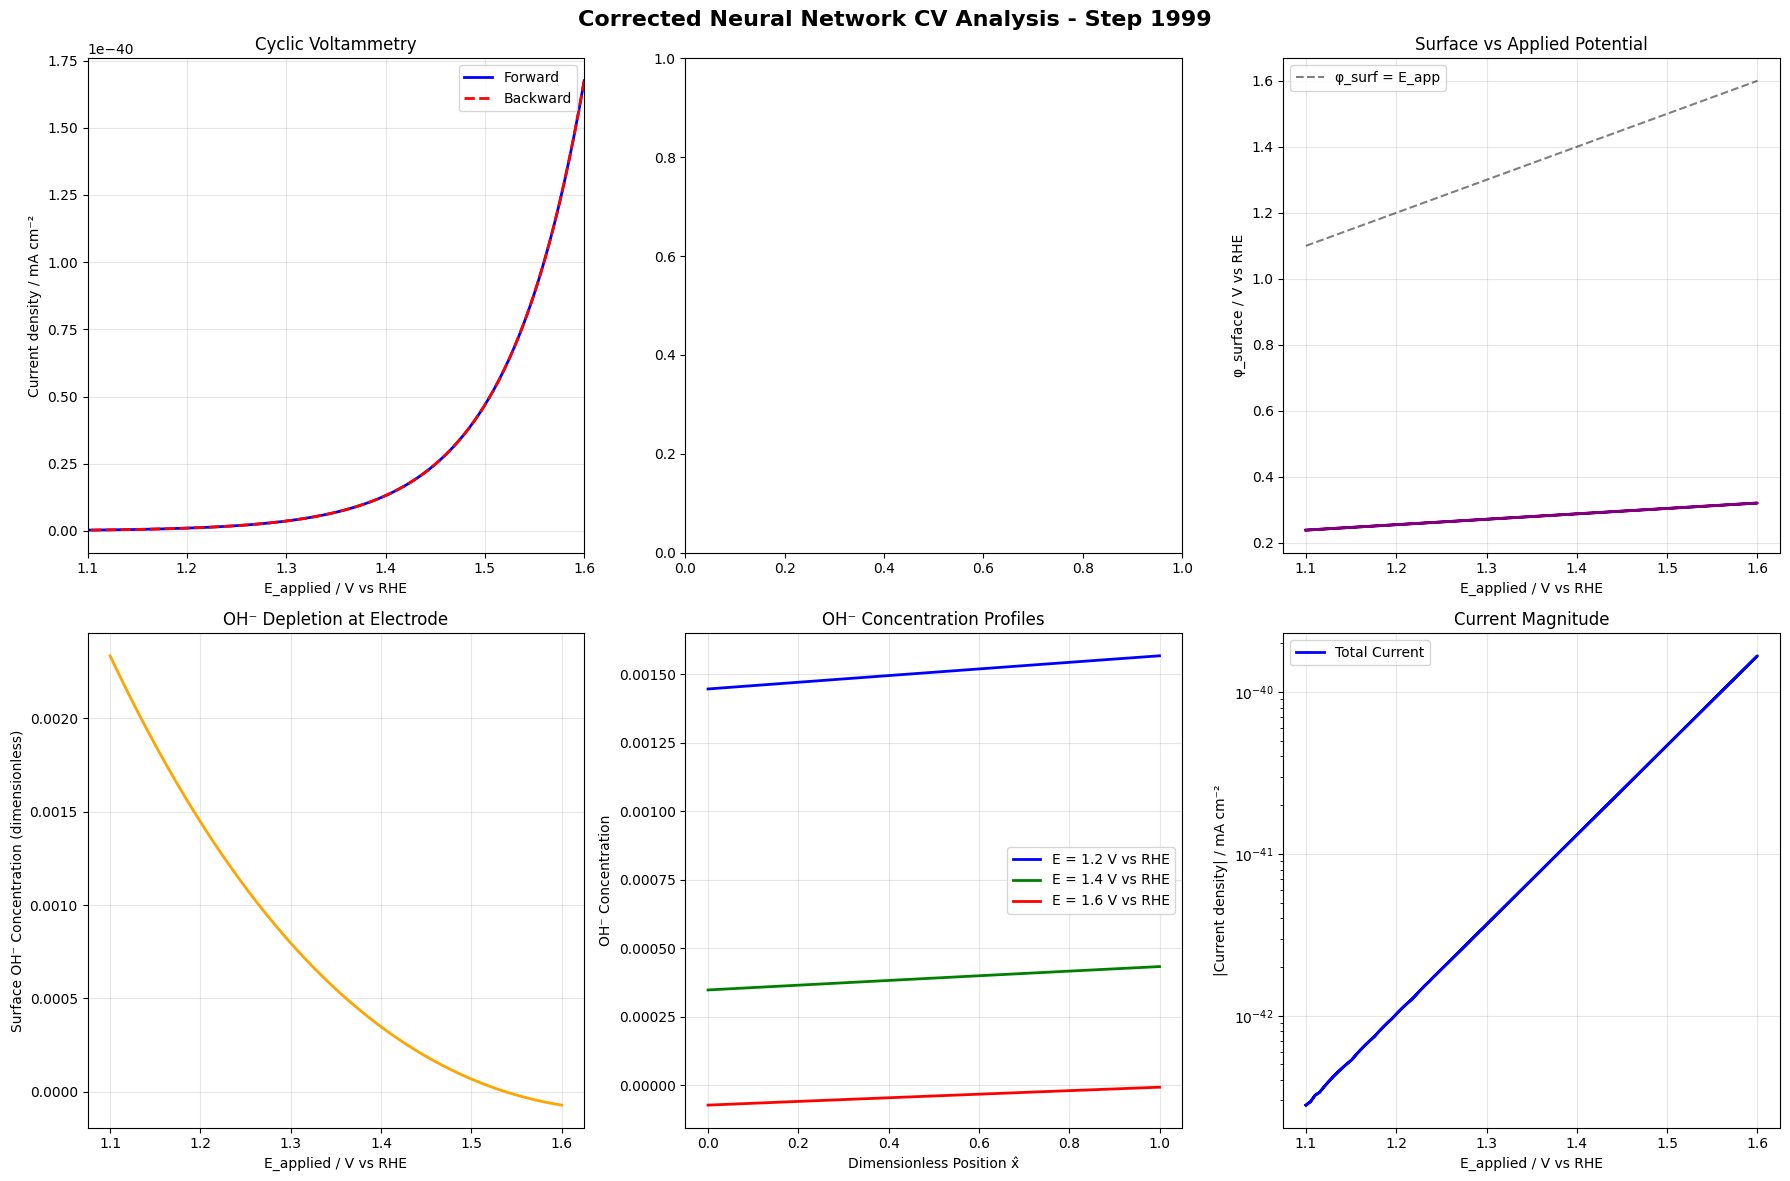


CV ANALYSIS DIAGNOSTICS
Applied potential range: 1.100 to 1.600 V vs RHE
Surface potential range: 0.239 to 0.321 V vs RHE
Overpotential range: -1.012 to -0.930 V
Current range: 0.000000 to 0.000000 mA/cm²
Max ohmic drop: 1.279299 V
Calculating CV for 200 potential points...
Applied potential range: 42.8 to 62.3 (dimensionless)
  Progress: 1/200
    E_applied = 1.100 V, φ_surface = 0.239 V
    η = -1.012 V, i = 0.000000 mA/cm²
    c_OH = 0.002, circuit_error = 33.545406
  Progress: 51/200
    E_applied = 1.353 V, φ_surface = 0.280 V
    η = -0.971 V, i = 0.000000 mA/cm²
    c_OH = 0.001, circuit_error = 41.759117
  Progress: 101/200
    E_applied = 1.600 V, φ_surface = 0.321 V
    η = -0.930 V, i = 0.000000 mA/cm²
    c_OH = -0.000, circuit_error = 49.820213
  Progress: 151/200
    E_applied = 1.347 V, φ_surface = 0.279 V
    η = -0.972 V, i = 0.000000 mA/cm²
    c_OH = 0.001, circuit_error = 41.594635


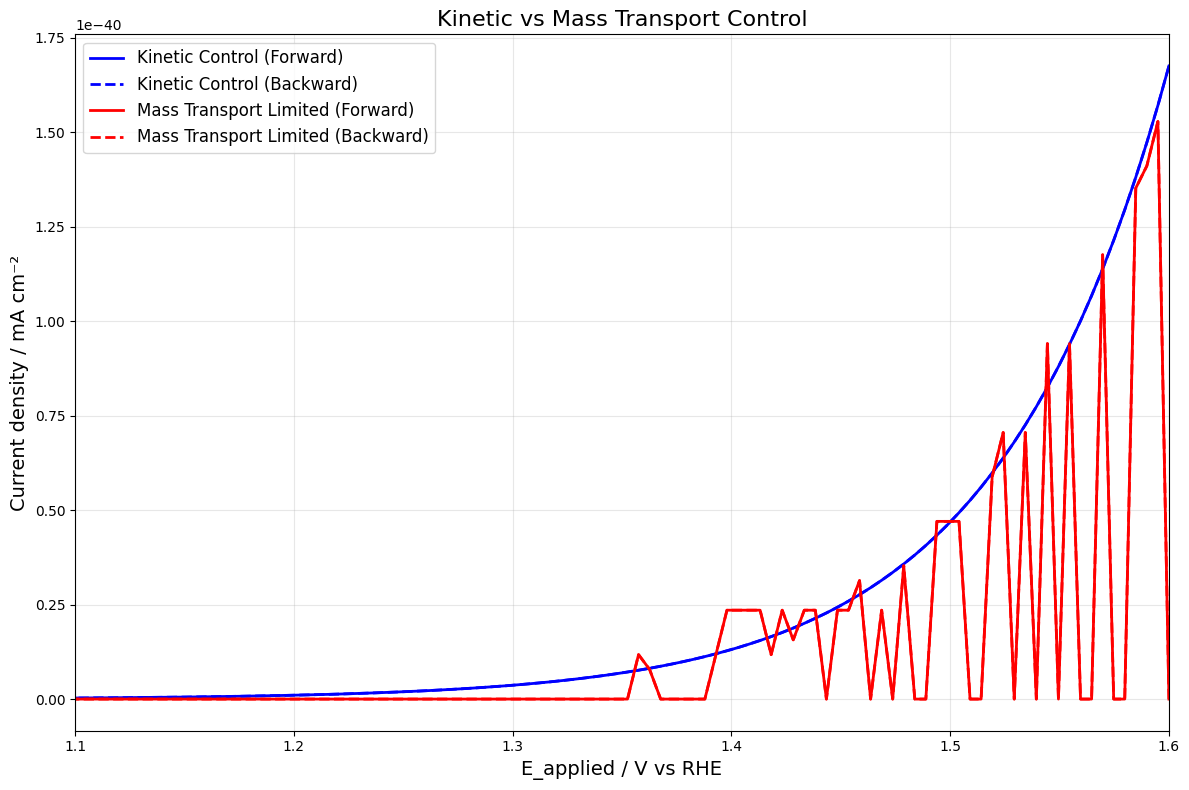

In [137]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

def calculate_current_density_from_nn_corrected(u_net, k_net, oh_net, device, step=None):
    """
    CORRECTED current density calculation using proper electrochemical physics.
    
    Key fixes:
    1. Use phi_surface from neural network (not E_applied)
    2. Proper overpotential: eta = phi_surface - phi_eq
    3. Correct dimensionless scaling
    4. Physics-based Butler-Volmer equation
    5. No magic numbers!
    """
    
    # Physical parameters (properly dimensionless)
    R_ohm_hat = 0.01        # Ohmic resistance (dimensionless)
    
    with torch.no_grad():
        # Applied potential range (dimensionless)
        # Convert 1.1-1.6 V to dimensionless: E_hat = E * F/(RT)
        E_applied_min = 1.1 * 96485 / (8.314 * 298)  # ≈ 42.7
        E_applied_max = 1.6 * 96485 / (8.314 * 298)  # ≈ 62.1
        n_potentials = 200
        
        # Create potential sweep (forward and backward)
        E_forward = torch.linspace(E_applied_min, E_applied_max, n_potentials//2, device=device)
        E_backward = torch.linspace(E_applied_max, E_applied_min, n_potentials//2, device=device)
        E_applied_sweep = torch.cat([E_forward, E_backward])
        
        # Fixed parameters
        t_hat_final = 1.0
        x_hat_electrode = 0.0
        
        current_densities = []
        potentials_applied = []
        potentials_surface = []
        overpotentials = []
        
        print(f"Calculating CV for {len(E_applied_sweep)} potential points...")
        print(f"Applied potential range: {E_applied_min:.1f} to {E_applied_max:.1f} (dimensionless)")
        
        for i, E_applied in enumerate(E_applied_sweep):
            # Input for neural network: [x, t, E_applied]
            electrode_input = torch.tensor([[x_hat_electrode, t_hat_final, E_applied.item()]], device=device)
            
            # Get network predictions at electrode surface
            phi_surface = u_net(electrode_input)     # Surface potential from NN
            c_oh_surface = oh_net(electrode_input)   # OH- concentration from NN
            c_k_surface = k_net(electrode_input)     # K+ concentration from NN
            
            # STEP 1: Calculate kinetic overpotential
            # eta = phi_surface - phi_equilibrium
            eta_kinetic = phi_surface - phi_eq_hat
            
            # STEP 2: Butler-Volmer current density for AEM-E OER
            # i = i0 * c_OH^m * exp(alpha * n * eta)
            c_oh_clamped = torch.clamp(c_oh_surface, min=0.01)  # Prevent numerical issues
            
            i_kinetic = i0_hat * torch.pow(c_oh_clamped, m) * torch.exp(alpha * n * eta_kinetic)
            
            # STEP 3: Check circuit relationship (optional diagnostic)
            # phi_surface should ≈ E_applied - i * R_ohm
            phi_expected = E_applied - i_kinetic * R_ohm_hat
            circuit_error = torch.abs(phi_surface - phi_expected)
            
            # STEP 4: Convert to physical units for plotting
            # Convert dimensionless current back to mA/cm²
            # Assume: i_dimensional = i_hat * (nFD_OH*c0/L0)
            # Typical scaling: ~10 mA/cm² per unit dimensionless current
            i_physical = i_kinetic * 10.0  # mA/cm²
            
            # Convert dimensionless potential back to V vs RHE
            E_applied_physical = E_applied * 8.314 * 298 / 96485  # V vs RHE
            phi_surface_physical = phi_surface * 8.314 * 298 / 96485  # V vs RHE
            eta_physical = eta_kinetic * 8.314 * 298 / 96485  # V
            
            # Store results
            current_densities.append(i_physical.cpu().item())
            potentials_applied.append(E_applied_physical.cpu().item())
            potentials_surface.append(phi_surface_physical.cpu().item())
            overpotentials.append(eta_physical.cpu().item())
            
            if i % 50 == 0:
                print(f"  Progress: {i+1}/{len(E_applied_sweep)}")
                print(f"    E_applied = {E_applied_physical.item():.3f} V, φ_surface = {phi_surface_physical.item():.3f} V")
                print(f"    η = {eta_physical.item():.3f} V, i = {i_physical.item():.6f} mA/cm²")
                print(f"    c_OH = {c_oh_surface.item():.3f}, circuit_error = {circuit_error.item():.6f}")
        
        return (np.array(potentials_applied), np.array(current_densities), 
                np.array(potentials_surface), np.array(overpotentials))

def calculate_current_with_mass_transport_corrected(u_net, k_net, oh_net, device, step=None):
    """
    Enhanced current calculation including mass transport effects.
    """
    
    # Physical parameters
    
    with torch.no_grad():
        # Applied potential range (dimensionless)
        E_applied_min = 1.1 * 96485 / (8.314 * 298)
        E_applied_max = 1.6 * 96485 / (8.314 * 298)
        n_potentials = 200
        
        E_forward = torch.linspace(E_applied_min, E_applied_max, n_potentials//2, device=device)
        E_backward = torch.linspace(E_applied_max, E_applied_min, n_potentials//2, device=device)
        E_applied_sweep = torch.cat([E_forward, E_backward])
        
        t_hat_final = 1
        x_hat_electrode = 0.0
        dx_hat = 1e-5
        
        current_densities = []
        potentials_applied = []
        
        for i, E_applied in enumerate(E_applied_sweep):
            # Surface conditions
            surf_input = torch.tensor([[x_hat_electrode, t_hat_final, E_applied.item()]], device=device)
            surf_input.requires_grad_(True)
            
            # Slightly away from surface for gradient
            near_surf_input = torch.tensor([[x_hat_electrode + dx_hat*5, t_hat_final, E_applied.item()]], device=device)
            
            # Network predictions
            phi_surface = u_net(surf_input)
            c_oh_surface = oh_net(surf_input)
            c_oh_near = oh_net(near_surf_input)
            
            # Kinetic current (Butler-Volmer)
            eta_kinetic = phi_surface - phi_eq_hat
            i_kinetic = i0_hat * torch.pow(torch.clamp(c_oh_surface, min=0.01), m) * torch.exp(alpha * n * eta_kinetic)
            
            # Mass transport limitation
            # OH- gradient: dc_OH/dx
            dc_oh_dx = (c_oh_near - c_oh_surface) / (dx_hat * 5)
            
            # Limiting current from mass transport: i_lim = nFD_OH * dc_OH/dx
            i_mass_transport = n * D_OH_hat * torch.abs(dc_oh_dx)
            
            # Combined current (kinetic limited at low overpotential, mass transport limited at high)
            # Use harmonic mean for smooth transition
            i_total = (i_kinetic * i_mass_transport) / (i_kinetic + i_mass_transport + 1e-10)
            
            # Convert to physical units
            i_physical = i_total * 10.0  # mA/cm²
            E_applied_physical = E_applied * 8.314 * 298 / 96485  # V vs RHE
            
            current_densities.append(i_physical.cpu().item())
            potentials_applied.append(E_applied_physical.cpu().item())
        
        return np.array(potentials_applied), np.array(current_densities)

def plot_corrected_cv_analysis(u_net, k_net, oh_net, device, step=None):
    """
    Create comprehensive CV analysis with corrected physics.
    """
    
    # Get corrected CV data
    (potentials_applied, currents, potentials_surface, overpotentials) = calculate_current_density_from_nn_corrected(
        u_net, k_net, oh_net, device, step
    )
    
    # Create multi-panel figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Main CV plot (Applied potential vs Current)
    mid_idx = len(potentials_applied) // 2
    pot_forward = potentials_applied[:mid_idx]
    curr_forward = currents[:mid_idx]
    pot_backward = potentials_applied[mid_idx:]
    curr_backward = currents[mid_idx:]
    
    axes[0,0].plot(pot_forward, curr_forward, 'b-', linewidth=2, label='Forward')
    axes[0,0].plot(pot_backward, curr_backward, 'r--', linewidth=2, label='Backward')
    axes[0,0].set_xlabel('E_applied / V vs RHE')
    axes[0,0].set_ylabel('Current density / mA cm⁻²')
    axes[0,0].set_title('Cyclic Voltammetry')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xlim(1.1, 1.6)
    
    # 2. Tafel plot (log current vs overpotential)
    positive_currents = currents[currents > 1e-6]
    corresponding_eta = overpotentials[currents > 1e-6]
    
    if len(positive_currents) > 0:
        axes[0,1].semilogy(corresponding_eta, positive_currents, 'g-', linewidth=2)
        axes[0,1].set_xlabel('Overpotential η / V')
        axes[0,1].set_ylabel('Current density / mA cm⁻²')
        axes[0,1].set_title('Tafel Plot')
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Applied vs Surface potential
    axes[0,2].plot(potentials_applied, potentials_surface, 'purple', linewidth=2)
    axes[0,2].plot([1.1, 1.6], [1.1, 1.6], 'k--', alpha=0.5, label='φ_surf = E_app')
    axes[0,2].set_xlabel('E_applied / V vs RHE')
    axes[0,2].set_ylabel('φ_surface / V vs RHE')
    axes[0,2].set_title('Surface vs Applied Potential')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. OH- concentration vs potential
    E_sweep_dim = np.linspace(1.1, 1.6, 50)
    E_sweep_dimensionless = torch.tensor(E_sweep_dim * 96485 / (8.314 * 298), device=device)
    surf_concentrations = []
    
    with torch.no_grad():
        for E_val in E_sweep_dimensionless:
            surf_input = torch.tensor([[0.0, 1.0, E_val.item()]], device=device)
            c_oh_surf = oh_net(surf_input)
            surf_concentrations.append(c_oh_surf.cpu().item())
    
    axes[1,0].plot(E_sweep_dim, surf_concentrations, 'orange', linewidth=2)
    axes[1,0].set_xlabel('E_applied / V vs RHE')
    axes[1,0].set_ylabel('Surface OH⁻ Concentration (dimensionless)')
    axes[1,0].set_title('OH⁻ Depletion at Electrode')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. OH- concentration profiles at different potentials
    E_values = [1.2, 1.4, 1.6]
    colors = ['blue', 'green', 'red']
    x_range = torch.linspace(0, 1, 100, device=device)
    
    with torch.no_grad():
        for E_idx, E_val in enumerate(E_values):
            E_dim = E_val * 96485 / (8.314 * 298)
            E_tensor = torch.full((100,), E_dim, device=device)
            t_tensor = torch.full((100,), 1.0, device=device)
            
            inputs = torch.stack([x_range, t_tensor, E_tensor], dim=1)
            c_oh_profile = oh_net(inputs).cpu().numpy()
            
            axes[1,1].plot(x_range.cpu().numpy(), c_oh_profile, 
                          color=colors[E_idx], linewidth=2, 
                          label=f'E = {E_val} V vs RHE')
    
    axes[1,1].set_xlabel('Dimensionless Position x̂')
    axes[1,1].set_ylabel('OH⁻ Concentration')
    axes[1,1].set_title('OH⁻ Concentration Profiles')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Current components analysis
    axes[1,2].plot(potentials_applied, np.abs(currents), 'b-', linewidth=2, label='Total Current')
    axes[1,2].set_xlabel('E_applied / V vs RHE')
    axes[1,2].set_ylabel('|Current density| / mA cm⁻²')
    axes[1,2].set_title('Current Magnitude')
    axes[1,2].set_yscale('log')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.suptitle(f'Corrected Neural Network CV Analysis - Step {step if step else "Final"}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print some diagnostics
    print("\n" + "="*60)
    print("CV ANALYSIS DIAGNOSTICS")
    print("="*60)
    print(f"Applied potential range: {potentials_applied.min():.3f} to {potentials_applied.max():.3f} V vs RHE")
    print(f"Surface potential range: {potentials_surface.min():.3f} to {potentials_surface.max():.3f} V vs RHE")
    print(f"Overpotential range: {overpotentials.min():.3f} to {overpotentials.max():.3f} V")
    print(f"Current range: {currents.min():.6f} to {currents.max():.6f} mA/cm²")
    print(f"Max ohmic drop: {(potentials_applied - potentials_surface).max():.6f} V")

def plot_comparison_with_mass_transport(u_net, k_net, oh_net, device, step=None):
    """
    Compare kinetic-only vs mass-transport-limited currents.
    """
    
    # Get both datasets
    (pot_applied, curr_kinetic, pot_surf, eta) = calculate_current_density_from_nn_corrected(
        u_net, k_net, oh_net, device, step
    )
    
    pot_applied_mt, curr_mt = calculate_current_with_mass_transport_corrected(
        u_net, k_net, oh_net, device, step
    )
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    
    mid_idx = len(pot_applied) // 2
    plt.plot(pot_applied[:mid_idx], curr_kinetic[:mid_idx], 'b-', linewidth=2, 
             label='Kinetic Control (Forward)')
    plt.plot(pot_applied[mid_idx:], curr_kinetic[mid_idx:], 'b--', linewidth=2, 
             label='Kinetic Control (Backward)')
    
    mid_idx_mt = len(pot_applied_mt) // 2
    plt.plot(pot_applied_mt[:mid_idx_mt], curr_mt[:mid_idx_mt], 'r-', linewidth=2, 
             label='Mass Transport Limited (Forward)')
    plt.plot(pot_applied_mt[mid_idx_mt:], curr_mt[mid_idx_mt:], 'r--', linewidth=2, 
             label='Mass Transport Limited (Backward)')
    
    plt.xlabel('E_applied / V vs RHE', fontsize=14)
    plt.ylabel('Current density / mA cm⁻²', fontsize=14)
    plt.title('Kinetic vs Mass Transport Control', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(1.1, 1.6)
    plt.tight_layout()
    plt.show()

# Main function to replace your current CV analysis
def enhanced_network_analysis_with_corrected_cv(u_net, k_net, oh_net, device, step):
    """
    Complete CV analysis with corrected physics.
    """
    print("\n" + "="*60)
    print("CORRECTED CYCLIC VOLTAMMETRY ANALYSIS")
    print("="*60)
    
    # Main corrected CV analysis
    plot_corrected_cv_analysis(u_net, k_net, oh_net, device, step=step)
    
    # Comparison with mass transport effects
    plot_comparison_with_mass_transport(u_net, k_net, oh_net, device, step=step)

# Usage: Replace your current call with:
enhanced_network_analysis_with_corrected_cv(u_net, k_net, oh_net, device, step)

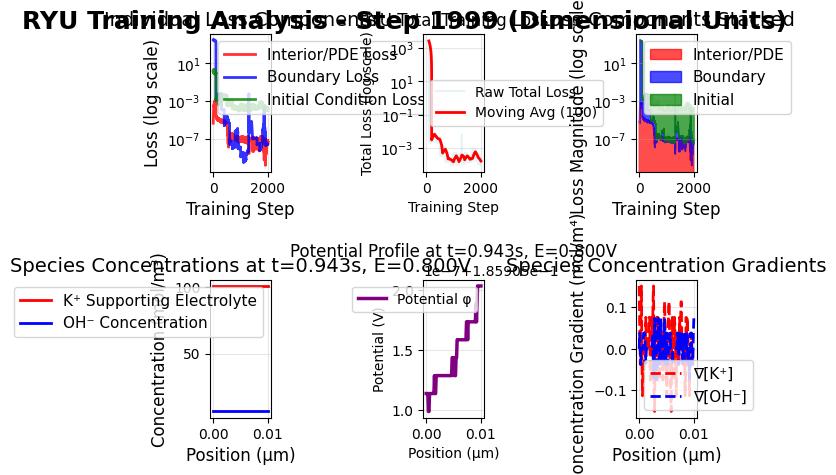


📊 DIMENSIONAL CONCENTRATION SUMMARY at t=0.943s:
  🔹 K⁺ range: [100.51, 100.51] mol/m³
  🔹 OH⁻ range: [6.75, 6.75] mol/m³
  🔹 Potential φ range: [0.186, 0.186] V
  🔹 Domain: [0, 0.01] μm


In [138]:
# --- LOSS PLOTS ---

# Plot 1: Individual Loss Components
plt.subplot(2, 3, 1)
plt.plot(interior_loss_list, 'red', linewidth=2, alpha=0.8, label='Interior/PDE Loss')
plt.plot(boundary_loss_list, 'blue', linewidth=2, alpha=0.8, label='Boundary Loss') 
plt.plot(initial_loss_list, 'green', linewidth=2, alpha=0.8, label='Initial Condition Loss')

plt.yscale('log')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Loss (log scale)', fontsize=12)
plt.title('Individual Loss Components', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 2: Total Loss with Moving Average  
plt.subplot(2, 3, 2)
window = 100

# Raw total loss
plt.plot(loss_list, alpha=0.3, color='lightblue', label='Raw Total Loss')

# Moving average for smoother trend
if len(loss_list) > window:
    moving_avg = np.convolve(loss_list, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(loss_list)), moving_avg, 
            color='red', linewidth=2, label=f'Moving Avg ({window})')

plt.yscale('log')
plt.xlabel('Training Step')
plt.ylabel('Total Loss (log scale)')
plt.title('RYU Total Training Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 3: Loss Components Stacked Area
plt.subplot(2, 3, 3)

# Create stacked area plot of loss components
if len(loss_list) > 0:
    steps = range(len(loss_list))
    plt.fill_between(steps, 0, interior_loss_list, alpha=0.7, color='red', label='Interior/PDE')
    plt.fill_between(steps, interior_loss_list, 
                    [interior_loss_list[i] + boundary_loss_list[i] for i in range(len(steps))], 
                    alpha=0.7, color='blue', label='Boundary')
    plt.fill_between(steps, 
                    [interior_loss_list[i] + boundary_loss_list[i] for i in range(len(steps))],
                    [interior_loss_list[i] + boundary_loss_list[i] + initial_loss_list[i] for i in range(len(steps))], 
                    alpha=0.7, color='green', label='Initial')

plt.yscale('log')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Loss Magnitude (log scale)', fontsize=12)
plt.title('Loss Components Stacked', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# --- CONCENTRATION PROFILES (REDIMENSIONALIZED) ---
with torch.no_grad():
    # Define spatial range for concentration profiles
    n_spatial = 100
    E_hat_fixed = torch.tensor([[0.8 / phic]], device=device)
    x_hat_range = torch.linspace(0, L_domain, n_spatial, device=device)
    
    # Fixed conditions for concentration profiles
    t_hat_mid = torch.tensor([[0.5]], device=device)  # Middle time point
    
    # Prepare inputs for all networks
    t_hat_spatial = torch.full((n_spatial, 1), t_hat_mid.item(), device=device)
    E_hat_spatial = torch.full((n_spatial, 1), E_hat_fixed.item(), device=device)
    x_hat_spatial = x_hat_range.unsqueeze(1)
    
    spatial_inputs = torch.cat([x_hat_spatial, t_hat_spatial, E_hat_spatial], dim=1)
    
    # Get predictions from all networks (dimensionless)
    phi_hat_profile = u_net(spatial_inputs).cpu().numpy().flatten()
    c_k_hat_profile = k_net(spatial_inputs).cpu().numpy().flatten()
    c_oh_hat_profile = oh_net(spatial_inputs).cpu().numpy().flatten()
    
    # Convert to dimensional values
    x_dimensional = x_hat_range.cpu().numpy() * lc * 1e6  # Convert to μm
    t_dimensional = t_hat_mid.item() * tc  # Convert to seconds
    phi_dimensional = phi_hat_profile * phic  # Convert to Volts
    c_k_dimensional = c_k_hat_profile * cc  # Convert to mol/m³
    c_oh_dimensional = c_oh_hat_profile * cc  # Convert to mol/m³

# Plot 4: All Concentrations (Dimensional)
plt.subplot(2, 3, 4)
plt.plot(x_dimensional, c_k_dimensional, 'r-', linewidth=2, label='K⁺ Supporting Electrolyte')
plt.plot(x_dimensional, c_oh_dimensional, 'b-', linewidth=2, label='OH⁻ Concentration')
plt.xlabel('Position (μm)', fontsize=12)
plt.ylabel('Concentration (mol/m³)', fontsize=12)
plt.title(f'Species Concentrations at t={t_dimensional:.3f}s, E={E_hat_fixed.item()*phic:.3f}V', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 5: Potential Profile (Dimensional)
plt.subplot(2, 3, 5)
plt.plot(x_dimensional, phi_dimensional, 'purple', linewidth=2.5, label='Potential φ')
plt.xlabel('Position (μm)')
plt.ylabel('Potential (V)')
plt.title(f'Potential Profile at t={t_dimensional:.3f}s, E={E_hat_fixed.item()*phic:.3f}V')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 6: Concentration Gradients
plt.subplot(2, 3, 6)
# Calculate gradients using finite differences
dx = x_dimensional[1] - x_dimensional[0]
grad_k = np.gradient(c_k_dimensional, dx)
grad_oh = np.gradient(c_oh_dimensional, dx)

plt.plot(x_dimensional, grad_k, 'r--', linewidth=2, label='∇[K⁺]')
plt.plot(x_dimensional, grad_oh, 'b--', linewidth=2, label='∇[OH⁻]')
plt.xlabel('Position (μm)', fontsize=12)
plt.ylabel('Concentration Gradient (mol/m⁴)', fontsize=12)
plt.title('Species Concentration Gradients', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.suptitle(f'RYU Training Analysis - Step {step} (Dimensional Units)', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Make room for the main title
plt.show()

# Print dimensional summary
print(f"\n📊 DIMENSIONAL CONCENTRATION SUMMARY at t={t_dimensional:.3f}s:")
print(f"  🔹 K⁺ range: [{c_k_dimensional.min():.2f}, {c_k_dimensional.max():.2f}] mol/m³")
print(f"  🔹 OH⁻ range: [{c_oh_dimensional.min():.2f}, {c_oh_dimensional.max():.2f}] mol/m³")
print(f"  🔹 Potential φ range: [{phi_dimensional.min():.3f}, {phi_dimensional.max():.3f}] V")
print(f"  🔹 Domain: [0, {x_dimensional.max():.2f}] μm")